# Differential abundance analysis in time - Myeloid cells

In this notebook we test for differential abundance across gestation in immune cell populations using Milo (python implementation [milopy](https://github.com/emdann/milopy))

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
from scipy.sparse import csr_matrix

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

Utility functions

In [9]:
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample.lanes"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)

def _milo_test_by_organ(adata, design="~ Sort_id + age_bins", sample_col="Sample.lanes", test_organs = None):  
    if test_organs is None:
        ## Keep organs covering at least two time-points
        df = adata.obs[["organ",sample_col, "age_bins"]].drop_duplicates()
        df = df.groupby(["organ","age_bins"]).count().reset_index().pivot("organ",columns="age_bins")
        sampled_organs = df.index[(df > 0).sum(1) > 2]
    else:
        sampled_organs = test_organs

    ## Calculate logFC and SpatialFDR within each organ
    milo_res_dict = {}
    for org in sampled_organs:
        print(org)
        org_samples = adata.obs[adata.obs["organ"] == org][sample_col].unique()
        milo.DA_nhoods(adata, design=design, subset_samples=org_samples)
        milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

    ## Collapse results
    logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
    for k,v in milo_res_dict.items():
        milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
        milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

    org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
    org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)
    return(milo_res_dict, org_fc, org_fdr)

Load FACS sorting proportion info

In [29]:
facs_prop_df = pd.read_csv("../../metadata/220621_FACs_gating_proportions_correct.csv")

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

facs_prop_df['file'] = facs_prop_df['Sample.lanes']

### Load dataset

In [11]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/'
split='MYELOID_V2'

In [9]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.raw_count.20210429.{s}.embedding.h5ad'.format(s=split))

In [51]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

### Preparations

In [30]:
## Filter out maternal contaminants
adata = adata[~adata.obs['is_maternal_contaminant']].copy()

## Add to obs info about FACS proportions
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names
adata.obs = new_obs.drop("_merge", 1).copy()

In [31]:
## Split gestational age into bins
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]

adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

## Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes

## Keep cd45+, cd45- and unsorted cells
### Fix sort ids
adata.obs["Sort_id"] = ["CD45P" if x == "CD45P_CD45N" else x for x in adata.obs["Sort_id"]]
adata.obs["Sort_id"] = ["CD45N" if x == "CD45EN" else x for x in adata.obs["Sort_id"]]

### Exclude cells from unconventional sorts
adata = adata[adata.obs["Sort_id"].isin(["CD45P", "CD45N", "TOT"])]
### Exclude CD45P/N cells that don't have true fraction quantification (mainly Gut)
adata = adata[~(adata.obs["Sort_id"].isin(["CD45P", "CD45N"]) & adata.obs["sort.ids"].isna())]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 214874 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'orig.ident', 'Sample.lanes', 'sort.ids', 'origin', 'count', 'total_live_events', 'parent_Multiplier', 'remarks', 'sort_sample_id', 'age_bins'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

### Define neighbourhoods

In [36]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

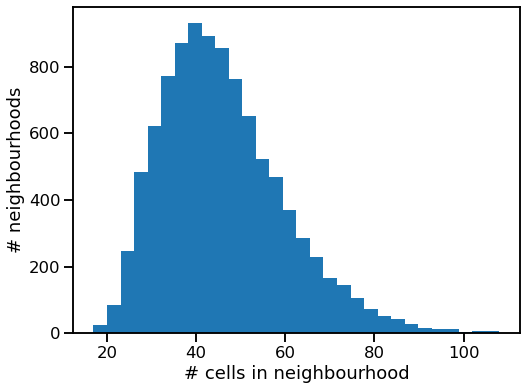

In [37]:
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [8,6]
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=30);
plt.xlabel('# cells in neighbourhood'); plt.ylabel('# neighbourhoods');
plt.savefig(figdir+'nhood_size_hist.pdf',bbox_inches='tight');

### Run differential abundance test

In [68]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["Sort_id"]=="TOT","correction_factor"] = 0

# ## Convert age bins to numerical
# adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes
# milopy.utils.add_covariate_to_nhoods_var(adata, ['age_bins'])

## Test by organ
milo_res_2, org_fc_2, org_fdr_2 = _milo_test_by_organ(adata, 
                                                      design="~ correction_factor + age_bins",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

## Exclude neighbourhoods where DA is explained by 10X protocol
# (eliminates false positives in the thymus, where there is partial
# confounding between method and age bins)
milo_res_method, org_fc_method, org_fdr_method = _milo_test_by_organ(adata, 
                                                      design="~ method",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

org_fc_filtered = org_fc_2.copy()
org_fdr_filtered = org_fdr_2.copy()
for o in ["BM", "LI", "SK", "SP", "TH"]:
    org_fc_filtered["logFC_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan
    org_fdr_filtered["SpatialFDR_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan


Trying to set attribute `.var` of view, copying.


BM
LI
SK
SP
TH
BM
LI
SK
SP
TH


#### QC plots

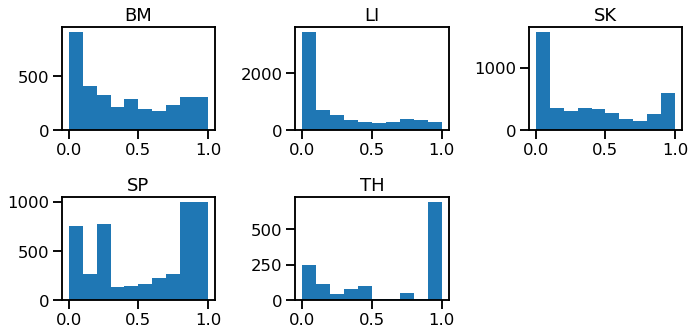

In [69]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.hist(milo_res_2[k].PValue);
    plt.title(k);
    plt.tight_layout();
    i+=1

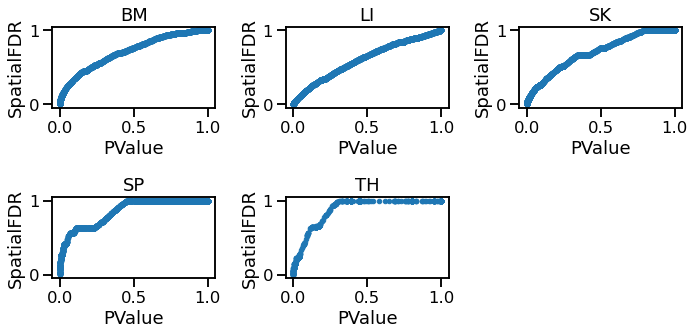

In [70]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.plot(milo_res_2[k].PValue, milo_res_2[k].SpatialFDR, '.');
    plt.title(k);
    plt.tight_layout();
    plt.xlabel("PValue");
    plt.ylabel("SpatialFDR");
    i+=1

Annotate neighbourhoods

In [71]:
## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"
org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

org_fc_filtered['Nhood'] = org_fc_filtered.index 
org_fdr_filtered['Nhood'] = org_fdr_filtered.index 

In [76]:
long_org_fc_filtered = org_fc_filtered.melt(id_vars=['nhood_anno', 'anno_group', "Nhood"], 
                                            value_name='logFC',
                                            var_name='organ'
                                           )
long_org_fdr_filtered = org_fdr_filtered.melt(id_vars=["Nhood"], 
                                              value_name='SpatialFDR',
                                             var_name='organ'
                                             )

long_org_fc_filtered['organ'] = [x[1] for x in long_org_fc_filtered['organ'].str.split('_')]
long_org_fdr_filtered['organ'] = [x[1] for x in long_org_fdr_filtered['organ'].str.split('_')]

pl_df = pd.merge(long_org_fc_filtered, long_org_fdr_filtered)

In [88]:
pl_df

,nhood_anno,anno_group,Nhood,organ,logFC,SpatialFDR
0,PROMONOCYTE,MYELOID,0,BM,NaN,NaN
1,MONOCYTE_III_IL1B,MYELOID,1,BM,NaN,NaN
2,MONOCYTE_II_CCR2,MYELOID,2,BM,NaN,NaN
3,MONOCYTE_III_IL1B,MYELOID,3,BM,NaN,NaN
4,MONOCYTE_III_IL1B,MYELOID,4,BM,NaN,NaN
...,...,...,...,...,...,...
48725,CYCLING_PDC,MYELOID,9741,TH,-0.369046,1.0
48726,CYCLING_PDC,MYELOID,9742,TH,NaN,NaN
48727,PDC,MYELOID,9743,TH,-0.014033,1.0
48728,PDC,MYELOID,9744,TH,-1.227503,1.0


#### Plot graph embeddings

In [367]:
milopy.utils.build_nhood_graph(adata)

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


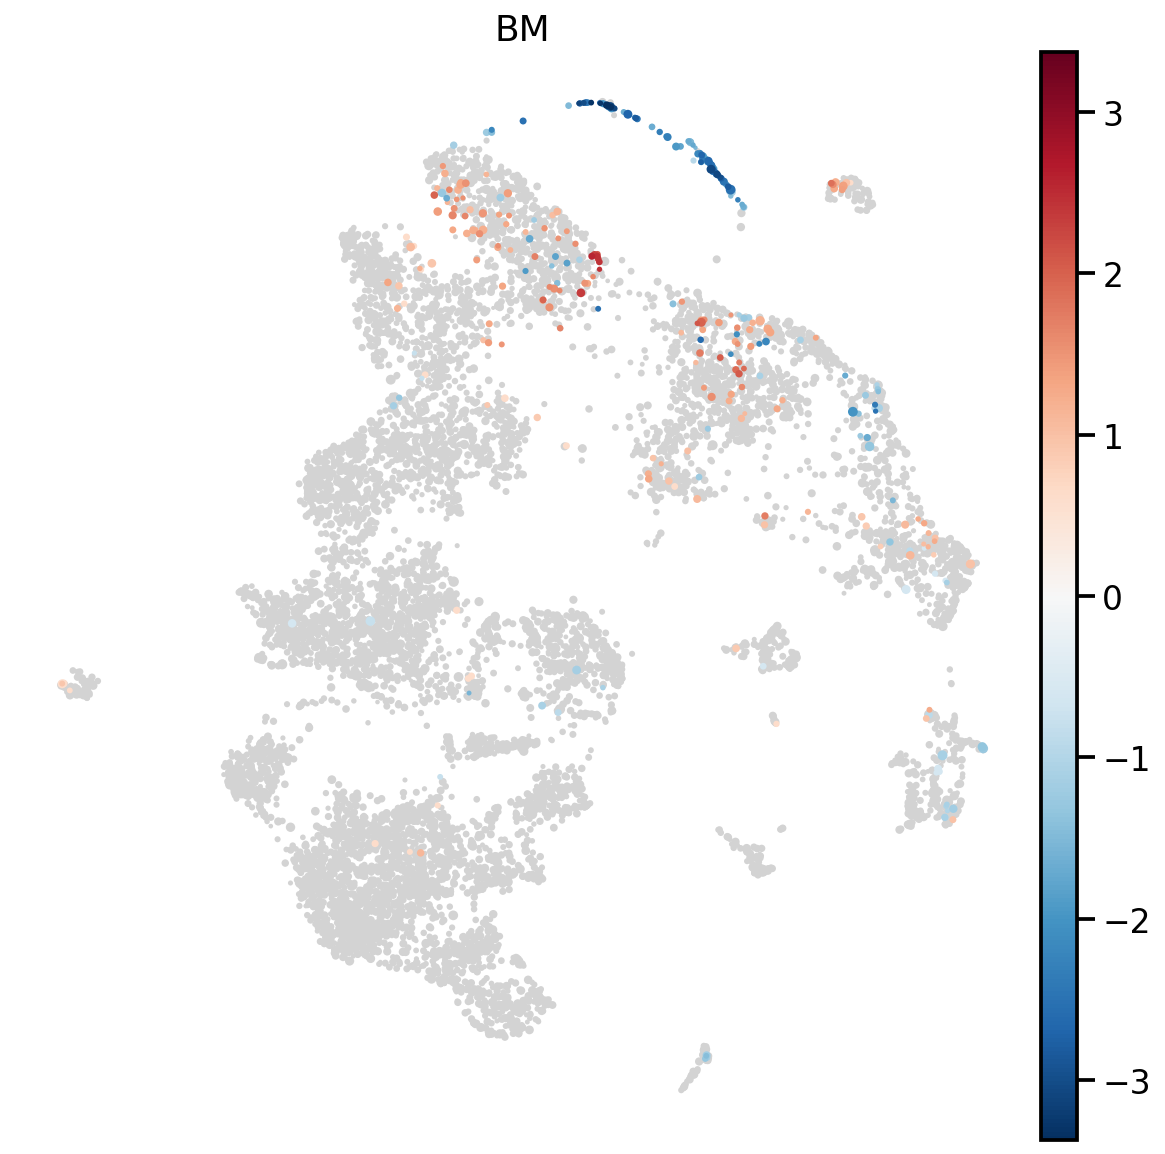

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


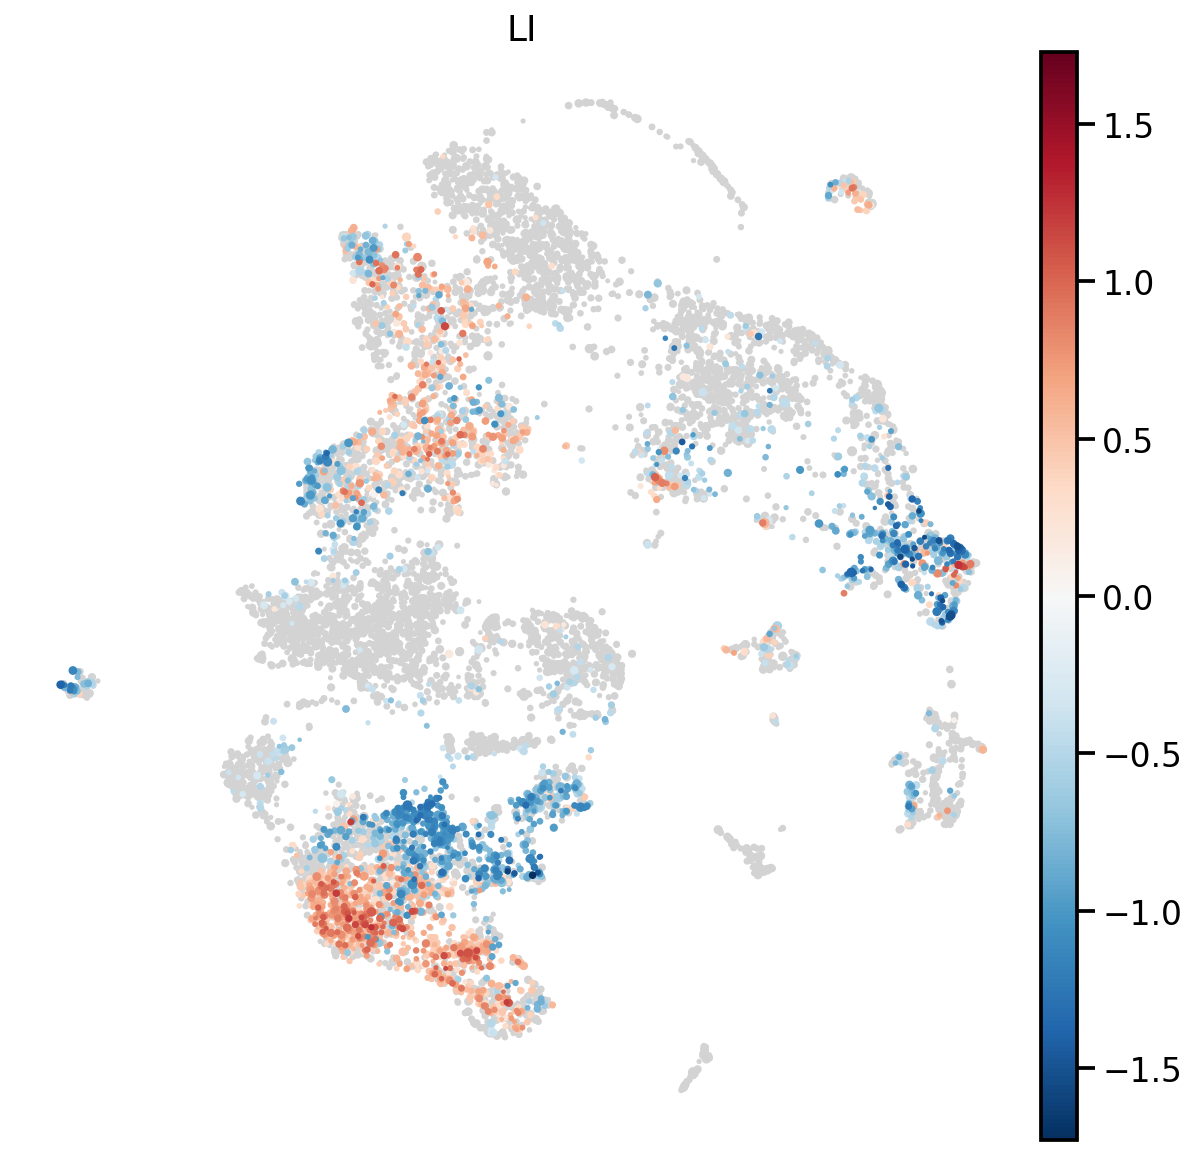

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


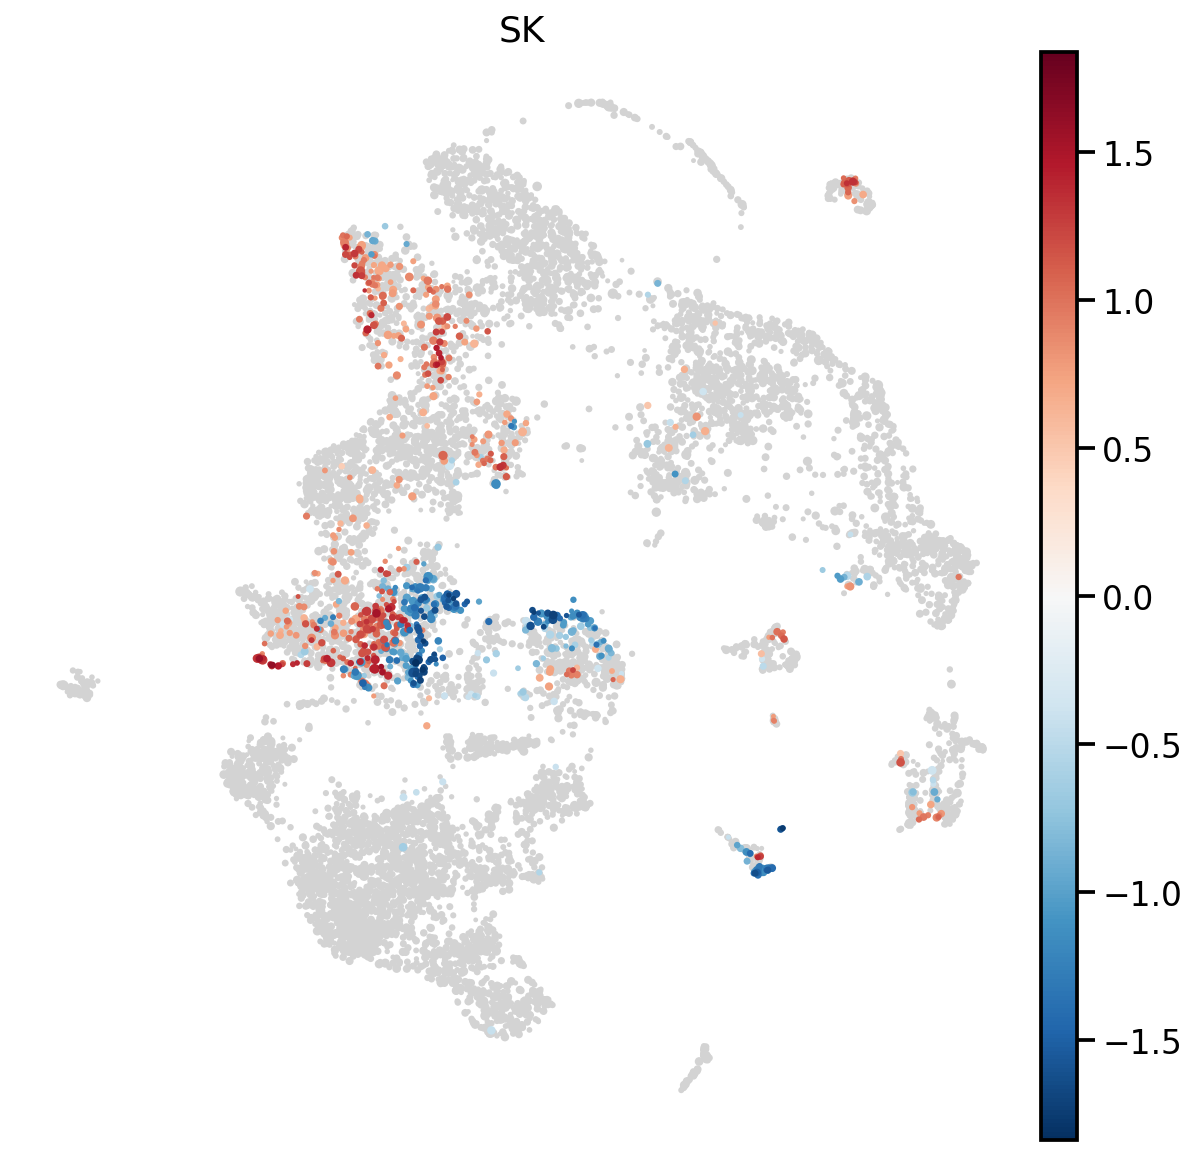

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


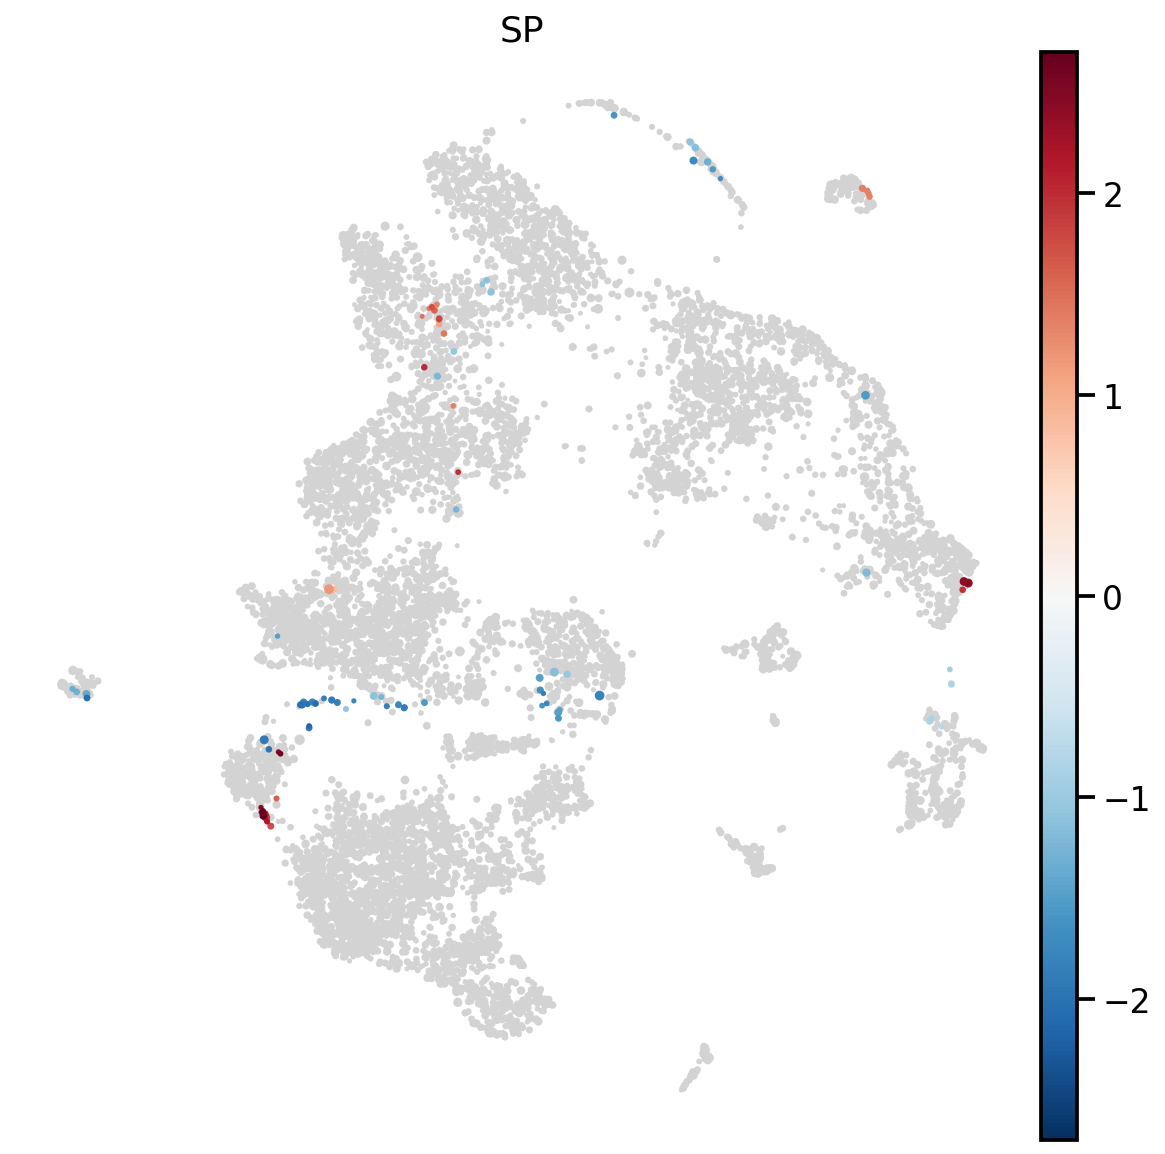

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


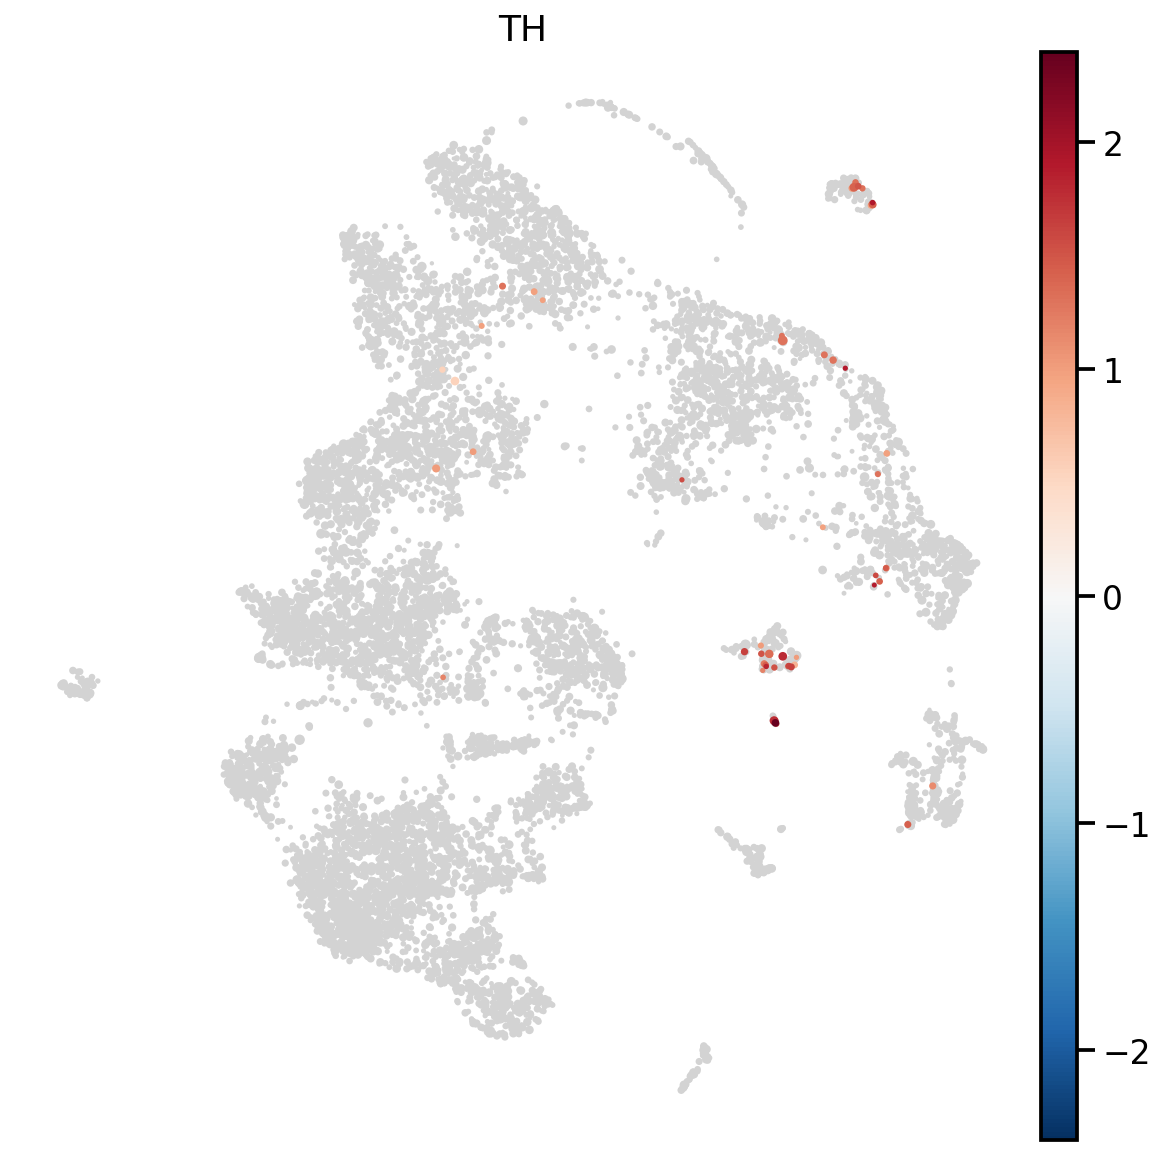

In [374]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_2.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.1, 
                            min_logFC= 0, min_size=1, title=org,save='nhood_graph_{o}.pdf'.format(o=org))

### Save processed outputs

In [12]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}_v2/'.format(s=split)

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [16]:
outdir

'/nfs/team205/ed6/data/Fetal_immune/milo_outs/MYELOID_V2_v2/'

In [103]:
## Save dataframe for beeswarm plot
pl_df.to_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))

In [375]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]

In [376]:
# adata.obs.drop("remarks", axis=1, inplace=True)
adata.obs.drop("Sample.lanes", axis=1, inplace=True)
adata.write_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

In [377]:
nhood_adata.var.drop(["Sample.lanes"], axis=1, inplace=True)
nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

In [29]:
## Read processed outputs
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))
pl_df = pd.read_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

In [30]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']

### Differential expression analysis

In [13]:
def test_DGE(adata, long_org_fc, subset_organ, subset_anno, alpha=0.1, 
             condition='signif_late', test_type='vs_rest',
                max_frac = 0.8
            ):
    '''
    Extract cells in neighbourhoods with significant enrichment in early or late cells and use 
    simple scanpy test to find markers VS the rest of cells in the same organ/annotation.
    
    Params:
    -------
    - long_org_fc: long format dataframe containing milo testing results
    - subset_organ: list of organs to test in
    - subset_anno: list or cell types to test in (values or `anno_lvl_2_final_clean`)
    - alpha: significance FDR threshold (default=0.1)
    - condition: which condition to compare to the rest? (either `signif_late` or `signif_early`)
    - test_type: 'vs_rest' condition VS all other cells, 'vs_opposite' condition VS opposite condition
    - max_frac: exclude genes that are expressed in more than this fraction of cells in all age bins 
    (to exclude very highly expressed genes in all the cluster)
    '''
    keep_nhoods_df = long_org_fc[(long_org_fc.organ.isin(subset_organ)) & (long_org_fc.nhood_anno.isin(subset_anno))][["Nhood", "test_label"]]
    pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == condition]["Nhood"].astype('int')

    cells_in_nhoods = adata.obsm["nhoods"][:,pick_nhoods].toarray().sum(1) > 0
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))

    test_adata = adata[cells_in_org]
    
    ## Define case VS control
    case_cells = adata[cells_in_org & cells_in_nhoods].obs_names
    if test_type == "vs_rest":
        test_adata.obs["test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
    elif test_type == 'vs_opposite':
        test_adata.obs["test_condition"] = np.nan
        all_conditions = ['signif_early', 'signif_late']
        opposite_condition = [x for x in all_conditions if x != condition][0]
        opposite_pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == opposite_condition]["Nhood"].astype('int')
        opposite_cells_in_nhoods = adata.obsm["nhoods"][:,opposite_pick_nhoods].toarray().sum(1) > 0
        opposite_case_cells = adata[cells_in_org & opposite_cells_in_nhoods].obs_names
        test_adata.obs.loc[opposite_case_cells, "test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
        
    ## Filter genes that are highly expressed everywhere
    high_x = np.empty(shape=(test_adata.n_vars,1))
    for b in test_adata.obs['age_bins'].unique():
        X_bin = test_adata[test_adata.obs['age_bins']==b].X
        nonz_X_bin = X_bin != 0
        top_n_cells = np.round(nonz_X_bin.shape[0]*max_frac)
        high_x_b = np.array(nonz_X_bin.sum(0)).ravel() >= top_n_cells
        high_x = np.hstack([high_x, high_x_b.reshape((test_adata.n_vars,1))])

    high_x =high_x[:,1:]
    keep_vars = test_adata.var_names[np.where(high_x.sum(1) < high_x.shape[1])[0]]
    test_adata = test_adata[:,test_adata.var_names.isin(keep_vars)]

#     if len(case_cells) < 10:
    sc.tl.rank_genes_groups(test_adata, groupby="test_condition", groups=["case"], reference="control")
    
    ## Get dataframe of results
    dge_dict = test_adata.uns['rank_genes_groups'].copy()
    dge_dict.pop("params")
    dge_dict = {k:[x[0] for x in dge_dict[k]] for k,v in dge_dict.items()}
    dge_df = pd.DataFrame.from_dict(dge_dict)
    
    return(test_adata, dge_df)

def get_top_DEGs(dge_df, FC_direction = None, n_genes=30, min_fc=None, alpha=0.001):
    ## Extract top genes and order by FC
    dge_df = dge_df[dge_df['pvals_adj'] < alpha]
    dge_df['abs_logfoldchanges'] = np.abs(dge_df['logfoldchanges'])
    ## Filter out very large lfc (see glmGamPoi docs)
    dge_df = dge_df[dge_df['abs_logfoldchanges'] < 10]
    genes_df = dge_df.sort_values("abs_logfoldchanges", ascending=False)
#     genes_df = dge_df.sort_values("pvals_adj")
    if min_fc is not None:
        genes_df = genes_df[np.abs(genes_df.logfoldchanges) > min_fc]
    if FC_direction is not None:
        genes_df = genes_df[np.sign(genes_df.logfoldchanges) == FC_direction]
    genes = genes_df.iloc[0:n_genes].sort_values("logfoldchanges", ascending=False).names.values
    return(genes)

def plot_DGE(test_adata, dge_df, subset_organ, subset_anno, FC_direction = None,  min_fc=0.1, n_genes=30, figsize=[4,10], save=False, **kwargs):
    ## Extract top genes and order by FC
    genes = get_top_DEGs(dge_df, FC_direction = FC_direction, n_genes=n_genes,  min_fc=None)
  
    #     genes_dict = {}
    #     genes_dict["down"] = genes_df[genes_df["logfoldchanges"] < 0]['names'].values
    #     genes_dict["up"] = genes_df[genes_df["logfoldchanges"] > 0]['names'].values
    
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.dotplot(test_adata, genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
#                          standard_scale="var",
                         return_fig=False, title=pl_title, swap_axes=True, show=False, 
                               figsize=figsize , **kwargs
                        );
    fig = plt.gcf()
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Median\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

In [14]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts), 'n' for n expressing
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    if agg=='n':
        adata.X[adata.X != 0] = 1
        pseudobulk_X = adata.X.T.dot(sample_dummies)
        ## Check that pseudobulk profiles are the sum of all profiles in a sample
        a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
        b = pseudobulk_X[:,0].toarray().flatten()
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]
    return(pseudobulk_adata)

In [ ]:
%%R -i cut_labels_4 
## Plotting function
plot_time_highlight <- function(X_pl_df, N_pl_df, genes, highlight_genes, mean_gex_limits=c(0,6)){

    pl_df <- left_join(
        X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
        N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
        ) %>%
        mutate(gene=factor(gene, levels=rev(genes))) %>%
        group_by(gene, organ) %>%
        mutate(mean_gex=scale(mean_gex, scale=FALSE, center=TRUE)) %>%
        mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
        mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
        mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

    highlight_df <- data.frame(gene=genes, organ='') %>%
        mutate(highlight=ifelse(gene %in% highlight_genes, gene, NA))

    highlight_pl <- pl_df %>%
        full_join(highlight_df) %>%
        mutate(gene=factor(gene, levels=levels(pl_df$gene))) %>%
        ggplot(aes(1, gene)) +
        ggrepel::geom_text_repel(data=. %>% filter(organ==""), aes(label=highlight),
                                 size=5,
                                  xlim = c(0.7,0.9), direction = "y", hjust = "left",
                                min.segment.length=0) +
        scale_x_continuous(expand=expansion(mult = c(0.3,0))) +
        cowplot::theme_nothing() +
                theme(plot.margin=margin(0, 0, 0, 0, "cm"))
    pl1 <- pl_df %>%
       ggplot(aes( age_bins, gene)) +
        geom_tile(aes(fill=mean_gex)) +
        facet_grid(.~organ, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
        scale_fill_distiller(palette='RdBu', name='Mean expression', limits=mean_gex_limits) +
        guides(fill=guide_colorbar()) +
        ylab("DEGs") + xlab("Age bins") +
        theme_classic(base_size=16) +
        remove_y_axis() +
        theme(axis.text.x=element_text(angle=45, hjust=1), 
              axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
             )
    (highlight_pl | pl1) +
        plot_layout(widths=c(1,3)) 
}

Calculate mean expression for each neighbourhood

In [32]:
long_org_fc = pl_df.copy()
alpha=0.1

## Log-normalize 
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10e4)
sc.pp.log1p(adata)

## Add mean expression for each neighbourhood
nhood_adata = adata.uns["nhood_adata"].copy()
X = adata.X
expr_id = "expr" 
## Aggregate over nhoods -- taking the mean
nhoods_X = X.T.dot(adata.obsm["nhoods"])

nhoods_X = csr_matrix(nhoods_X / adata.obsm["nhoods"].toarray().sum(0))
adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

Label neighbourhoods by outcome in each organ test

In [33]:
signif_early = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] < 0)
signif_late = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] > 0)
not_signif = (long_org_fc['SpatialFDR'] >= alpha)

long_org_fc['test_label'] = "not_signif"
long_org_fc.loc[signif_late, "test_label"] = "signif_late"
long_org_fc.loc[signif_early, "test_label"] = "signif_early"

In [68]:
def _save_DEGs(adata, long_org_fc, subset_anno,subset_organ,  condition):
    test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, 
                                  subset_anno, condition=condition, 
                                 max_frac=0.7, test_type='vs_rest'
                                 )
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=500,  min_fc=1)

    ## Save DEG table
    df = pd.DataFrame(genes, columns=['DEG'])
    df['annotation'] = subset_anno[0]
    df['organs'] = "-".join(subset_organ)
    dge_df.index = dge_df.names
    df.index = df.DEG
    df = pd.concat([df, dge_df.loc[df["DEG"]][['pvals', 'pvals_adj', 'logfoldchanges']]], 1)
    df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

query_sets = [
    [["MACROPHAGE_LYVE1_HIGH"],["SK"], "signif_early"],
    [["MACROPHAGE_PROLIFERATING"],["SK"], "signif_early"],
    [["MACROPHAGE_LYVE1_HIGH"],["LI"], "signif_early"],
    [["MACROPHAGE_PROLIFERATING"],["LI"], "signif_early"],
    [["MACROPHAGE_IRON_RECYCLING"],["LI"], "signif_late"], 
    [["MACROPHAGE_IRON_RECYCLING"],["SP"], "signif_late"], 
    [["MACROPHAGE_MHCII_HIGH"],["LI"], "signif_late"], 
    [['MAST_CELL'], ["LI"], 'signif_early']
]

In [69]:
for subset_anno,subset_organ, condition in query_sets:
    print(subset_anno)
    print(subset_organ)
    _save_DEGs(adata, long_org_fc, subset_anno,subset_organ, condition)

Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_LYVE1_HIGH']
['SK']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_PROLIFERATING']
['SK']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_LYVE1_HIGH']
['LI']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_PROLIFERATING']
['LI']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


['MACROPHAGE_IRON_RECYCLING']
['LI']


Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_IRON_RECYCLING']
['SP']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MACROPHAGE_MHCII_HIGH']
['LI']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.


['MAST_CELL']
['LI']


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [70]:
## Read results
all_degs_df=pd.DataFrame()
for subset_anno,subset_organ, condition in query_sets:
    df = pd.read_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=subset_organ[0]), index_col=0)
    all_degs_df= pd.concat([all_degs_df, df])

In [71]:
%%R -i all_degs_df
nrow(all_degs_df)

[1] 1427


In [107]:
## Save for supplementary material
all_degs_clean = all_degs_df.reset_index(drop=True).copy()
all_degs_clean.columns = ['DEG', "annotation_test", "organ_test", "pvals", 'pvals_adj', 'logfoldchanges']
cond_test_dict = {x[0][0]:x[2] for x in query_sets}
all_degs_clean['condition_test'] = [cond_test_dict[x] for x in all_degs_clean.annotation_test]
all_degs_clean.to_csv('/home/jovyan/mount/gdrive/Pan_fetal/writing/Suppl_info/DEGs_time_specific_neighbourhoods.MYELOID.csv')

### Enrichment analysis

In [222]:
# pip install gseapy

In [75]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

gp.__version__

names = gp.get_library_name() # default: Human

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
gene_sets=['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"]

# run enrichr
for gene_set in gene_sets:
    # if you are only intrested in dataframe that enrichr returned, please set no_plot=True
    for anno in np.unique([x[0] for x in query_sets]):
        id_name = "DEGS_" + anno
#         DGE = pd.read_csv(outdir+infile) 
        gene_list = all_degs_df['DEG'][all_degs_df['annotation'] == anno].unique().tolist()
        # list, dataframe, series inputs are supported
        enr = gp.enrichr(gene_list=gene_list,
                         gene_sets=[gene_set],
                         organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                         description=id_name,
                         outdir='enrichr/'+id_name+'/',
                         # no_plot=True,
                         cutoff=0.5 # test dataset, use lower value from range(0,1)
                        )
        # to save your figure, make sure that ``ofname`` is not Nonea
        ax=dotplot(enr.res2d, title=gene_set,cmap='RdYlBu_r',cutoff=1, top_terms=10,
                   figsize=(6,6),
                   ofname=figdir + id_name + gene_set + '.enrichr.pdf')

### Make plots

Macrophages

In [77]:
DE_genes_highlight = {
    'iron-recycling':['HMOX1', "BLVRB"],
    "proinflammatory":['IL1A', "CCL4L2", "CCL3L1","TNF", "CCL3", "CCL4", "CXCL8", "NFKBIA", "IL1B"],
    "immune\ndevelopment":["MARCO", 'IFIT2', "NAMPT"],
    'antigen-presentation':['HLA-DRB5', 'HLA-DRA', 'HLA-DPA1', 'C5AR1', 'FPR3', 'FPR2']
                     }

In [78]:
subset_organ = ['LI', "SP", "YS", "GU", "SK", 'BM']
subset_anno = ['MACROPHAGE_TREM2','MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_PROLIFERATING', 'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_MHCII_HIGH', 'MACROPHAGE_KUPFFER_LIKE']

In [79]:
## mean expression
genes = sum([list(x) for x in DE_genes_highlight.values()],[])
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [80]:
X_pl_df['annotation'] = [x[1] for x in X_pl_df['age_bins'].str.split("-")]
X_pl_df['age_bins'] = [x[0] for x in X_pl_df['age_bins'].str.split("-")]

In [81]:
N_pl_df['annotation'] = [x[1] for x in N_pl_df['age_bins'].str.split("-")]
N_pl_df['age_bins'] = [x[0] for x in N_pl_df['age_bins'].str.split("-")]

In [82]:
gene_anno_df = pd.DataFrame([(x,k) for k,v in DE_genes_highlight.items() for x in v])
gene_anno_df.columns = ['gene', 'gene_group']
gene_anno_df.index = gene_anno_df['gene']

In [87]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes -i gene_anno_df -i cut_labels_4
gene_anno <- setNames(gene_anno_df$gene_group, gene_anno_df$gene)
# head(gene_anno_df)
highlight_genes <- genes
mean_gex_limits=c(-3,3)
## Plotting function
pl_df <- 
left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU")))  %>%
    mutate(annotation=factor(str_remove(annotation, "MACROPHAGE_"), 
                             levels=c('TREM2','LYVE1_HIGH', 'PROLIFERATING', 'IRON_RECYCLING', 'MHCII_HIGH', 'KUPFFER_LIKE'))) %>%
    mutate(gene_group=gene_anno[as.character(gene)]) %>%
    mutate(gene_group=factor(gene_group, levels=c('iron-recycling', 'proinflammatory', 'immune\ndevelopment',
       'antigen-presentation')))

head(pl_df)

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
  n_cells organ age_bins     annotation   gene   mean_gex n_cells_gex
1    6893    LI  < 12pcw IRON_RECYCLING  HMOX1 4.12378550        6803
2    6893    LI  < 12pcw IRON_RECYCLING  BLVRB 4.06561327        6803
3    6893    LI  < 12pcw IRON_RECYCLING   IL1A 0.08071902         160
4    6893    LI  < 12pcw IRON_RECYCLING CCL4L2 2.52585626        4334
5    6893    LI  < 12pcw IRON_RECYCLING CCL3L1 2.30636191        4033
6    6893    LI  < 12pcw IRON_RECYCLING    TNF 1.37779355        2633
       gene_group
1  iron-recycling
2  iron-recycling
3 proinflammatory
4 proinflammatory
5 proinflammatory
6 proinflammatory


`summarise()` has grouped output by 'gene', 'age_bins', 'annotation'. You can override using the `.groups` argument.


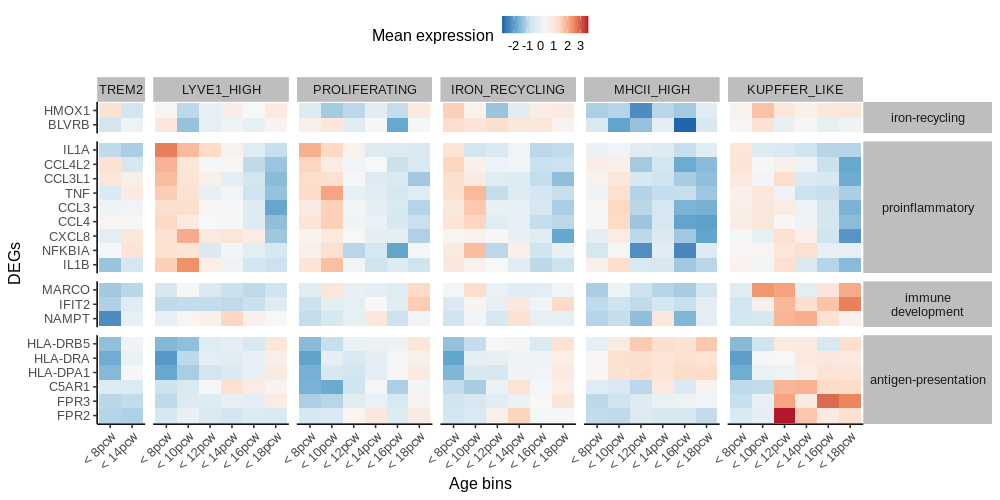

In [88]:
%%R -w 1000 -h 500                
pl1 <- pl_df %>%
    group_by(gene, age_bins, annotation, gene_group) %>%
    summarise(mean_gex=mean(mean_gex), n=n()) %>%
    group_by(gene) %>%
#     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) %>%
    mutate(mean_gex=(mean_gex - mean(mean_gex))/(sd(mean_gex))) %>%
   ggplot(aes( age_bins, gene)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~annotation, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
    scale_fill_distiller(palette='RdBu', name='Mean expression') +
    guides(fill=guide_colorbar()) +
    ylab("DEGs") + xlab("Age bins") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1), 
          strip.text.y=element_text(angle=0),
          strip.background=element_rect(fill='grey', color=NA),
          legend.position='top'
          #axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
         )

(pl1) 
#     ggsave(paste0(figdir,"macs_figure.png"), width=15, height=12) 

In [89]:
%%R -w 1000 -h 500
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

pl2 <- pl_df %>%
    ungroup() %>%
    distinct(age_bins, organ, annotation, n_cells) %>%
    group_by(age_bins, organ) %>%
    mutate(n_macs=sum(n_cells)) %>%
    ungroup() %>%
    ggplot(aes(age_bins, n_cells/n_macs, color=organ, fill=organ)) +
    geom_point(aes(size=n_cells)) +
    geom_line(aes(group=organ)) +
    scale_fill_manual(values=organ_palette) +
    scale_color_manual(values=organ_palette) +
    facet_grid(.~annotation, scales='free_x', space="free") +
    theme_classic(base_size=16) +
    ylab("Fraction of\nMacrophages") +
    theme(legend.position='top')

In [86]:
%%R -w 1200 -h 700
((pl2 + remove_x_axis()) / pl1 +
    plot_layout(heights=c(1,3), guides='collect') &
    theme(legend.position='top')) +
    ggsave(paste0(figdir, 'all_macs.pdf'), width=13, height=10) +
    ggsave(paste0(figdir, 'all_macs.png'), width=13, height=10)


Error in withVisible({ : object 'pl2' not found


Mast cells

In [333]:
subset_anno = ["MAST_CELL"]
subset_organ = ['YS', "LI", "SK"]
## mean expression
genes = all_degs_df[all_degs_df.annotation=="MAST_CELL"]['DEG']
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [334]:
## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

In [335]:
X_pl_df['annotation'] = [x[1] for x in X_pl_df['age_bins'].str.split("-")]
X_pl_df['age_bins'] = [x[0] for x in X_pl_df['age_bins'].str.split("-")]

In [336]:
N_pl_df['annotation'] = [x[1] for x in N_pl_df['age_bins'].str.split("-")]
N_pl_df['age_bins'] = [x[0] for x in N_pl_df['age_bins'].str.split("-")]

In [337]:
X_pl_df = X_pl_df[X_pl_df.n_cells > 30]
N_pl_df = N_pl_df[N_pl_df.n_cells > 30]

In [338]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i gene_anno_df
# gene_anno <- setNames(gene_anno_df$gene_group, gene_anno_df$gene)
# head(gene_anno_df)
# highlight_genes <- ordered_genes
mean_gex_limits=c(-3,3)
## Plotting function
pl_df <- 
left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(ordered_genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU")))  
#     mutate(annotation=factor(str_remove(annotation, "MACROPHAGE_"), 
#                              levels=c('TREM2','LYVE1_HIGH', 'PROLIFERATING', 'IRON_RECYCLING', 'MHCII_HIGH', 'KUPFFER_LIKE'))) 
#     mutate(gene_group=gene_anno[as.character(gene)])
#     mutate(gene_group=factor(gene_group, levels=c('iron-recycling', 'proinflammatory', 'immune\ndevelopment',
#        'antigen-presentation')))

head(pl_df)

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
  n_cells organ age_bins annotation  gene  mean_gex n_cells_gex
1     160    YS   < 8pcw  MAST_CELL   TNF 1.2962927          54
2     160    YS   < 8pcw  MAST_CELL CXCL3 2.0403485          78
3     160    YS   < 8pcw  MAST_CELL PCLAF 1.1850384          58
4     160    YS   < 8pcw  MAST_CELL CENPF 0.8885209          46
5     160    YS   < 8pcw  MAST_CELL  EGR2 0.5698878          34
6     160    YS   < 8pcw  MAST_CELL CXCL2 2.1692591          86


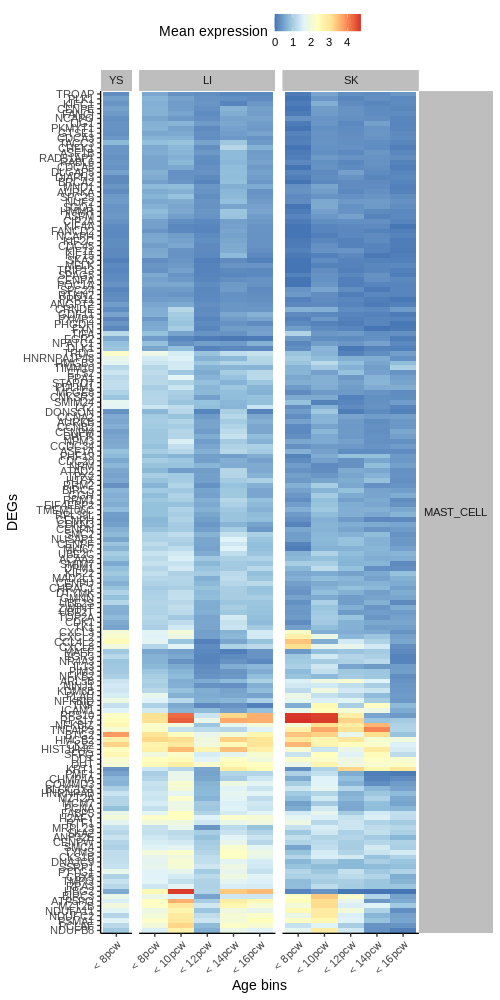

In [350]:
%%R -h 1000 -w 500                
pl1 <- pl_df %>%
#     group_by(gene, age_bins, annotation) %>%
#     summarise(mean_gex=mean(mean_gex), n=n()) %>%
#     group_by(gene) %>%
# #     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) %>%
#     mutate(mean_gex=(mean_gex - mean(mean_gex))/(sd(mean_gex))) %>%
   ggplot(aes( age_bins, gene)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(annotation~organ, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
    scale_fill_distiller(palette='RdYlBu', name='Mean expression') +
#     scale_fill_gradient(high='red', low='white', name='Mean expression') +
    guides(fill=guide_colorbar()) +
    ylab("DEGs") + xlab("Age bins") +
    theme_classic(base_size=14) +
    theme(axis.text.x=element_text(angle=45, hjust=1), 
          strip.text.y=element_text(angle=0),
          strip.background=element_rect(fill='grey', color=NA),
          legend.position='top'
          #axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
         )

(pl1) +
    ggsave(paste0(figdir,"mast_figure.png"), width=8, height=22) +
    ggsave(paste0(figdir,"mast_figure.pdf"), width=8, height=22) 

In [361]:
mac_degs = all_degs_df[all_degs_df['annotation'].isin(['MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_PROLIFERATING'])].DEG
mast_degs = all_degs_df[all_degs_df['annotation']=='MAST_CELL'].DEG

In [362]:
common_degs = mast_degs[mast_degs.isin(mac_degs)]
# all_degs_df[all_degs_df['annotation']!='MAST_CELL'][all_degs_df[all_degs_df['annotation']!='MAST_CELL'].DEG.isin(common_degs)]

In [363]:
common_degs

0          TNF
4         EGR2
5        CXCL2
10        MAFF
15        EGR3
20      CCL4L2
24       NR4A3
33       BIRC3
41        PLAU
42        PIM3
50       RPS10
61       CXCL8
71      NFKBIZ
73     TNFAIP3
84      TIMM10
88      NFKBID
113      ARL5B
120      ICAM1
123      KDM6B
129      NFKB2
131       BTG2
133      FABP5
134     NDUFC2
143    NDUFA11
157     NDUFB8
166    BLOC1S1
Name: DEG, dtype: object